In [1]:
from __future__ import print_function, division
import os
import glob
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import torch.nn as nn
from PIL import Image
import json
import random
import sys
import random
import numpy as np

in_notebooks_dir = (
    (os.path.basename(os.getcwd()) == 'notebooks') and 
    (os.path.exists(os.path.join(os.path.dirname(os.getcwd()), 'src')))
)
if in_notebooks_dir:
    os.chdir(os.path.dirname(os.getcwd()))

srcdir = os.path.join('..', 'src')
if srcdir not in sys.path:
    sys.path.insert(0, srcdir)

from src.preprocessing.torch_utils import reverse_image_standardisation

### Parse json file of fnames

In [2]:
preprocessing_dict = {
    "train": ["1319.png", "1320.png", "1321.png", "1322.png"],
    "val": ["1323.png", "1324.png"],
    "test": ["1325.png", "1326.png"]
}

### Make dataset class:

In [3]:
class SRDataset(Dataset):
    def __init__(self, fnames, img_dir, target_dir, transform=None, target_transform=None):
        super(Dataset, self).__init__()
        self.fnames = fnames
        self.img_dir = img_dir
        self.target_dir = target_dir
        self.transform = transform
        self.target_transform = target_transform
        self.img_paths = []
        self.target_paths = []
        for fname in fnames:
            self.img_paths.append(os.path.join(img_dir, fname))
            self.target_paths.append(os.path.join(target_dir, fname))
            
        for i, j in zip(self.img_paths, self.target_paths):
            if not (os.path.split(i)[-1]==os.path.split(j)[-1]):
                print('Img, target pair mismatch')

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        target_path = self.target_paths[idx]
 
        img = Image.open(img_path)
        target = Image.open(target_path)
        
        seed = np.random.randint(0, 2^31 -1)
        if self.transform is not None:
            random.seed(seed)
            torch.manual_seed(seed)
            img = self.transform(img)
        if self.target_transform is not None:
            random.seed(seed)
            torch.manual_seed(seed)
            target = self.target_transform(target)
        
        return img, target

### Load training dataset and calculate mean and standard devation across entire dataset

In [4]:
original_dataset = SRDataset(
    fnames = preprocessing_dict['train'],
    img_dir = 'data/raw/CGG_data/train/10x',
    target_dir = 'data/raw/CGG_data/train/gt',
    transform=transforms.ToTensor(),
    target_transform=transforms.ToTensor()
)

In [5]:
def calc_mean_and_std_for_rgb_dataset(dataset):
    '''
    Calculate mean and standard across inputs of training dataset
    Args: 
        dataset: SRDataset class object
    Returns:
        rgb_means, rgb_stds: mean and std for each channel
    '''
    
    tensor_list = []
    for img, target in dataset:
        target = None
        flat_img = torch.flatten(img, start_dim=1, end_dim=2)
        tensor_list.append(flat_img)

    concat_tensor_list = torch.cat(tensor_list, axis=1)
    rgb_means = torch.mean(concat_tensor_list, dim=1)
    rgb_stds = torch.std(concat_tensor_list, dim=1)
    return rgb_means, rgb_stds

In [6]:
rgb_means, rgb_stds = calc_mean_and_std_for_rgb_dataset(original_dataset)
print(rgb_means, rgb_stds)

tensor([0.4281, 0.4862, 0.4452]) tensor([0.1985, 0.1582, 0.1600])


### Find max width and height of images for padding desired_size parameter:

In [7]:
def return_max_heights_and_widths(dataset):
    i_heights, i_widths = [], []
    t_heights, t_widths = [], []
    for img, target in dataset:
        i_heights.append(img.size()[1])
        i_widths.append(img.size()[2])

        t_heights.append(target.size()[1])
        t_widths.append(target.size()[2])
        
    return max(i_heights), max(i_widths), max(t_heights), max(t_widths)

In [8]:
i_max_h, i_max_w, t_max_h, t_max_w = return_max_heights_and_widths(original_dataset)
print(i_max_h, i_max_w, t_max_h, t_max_w)

106 103 1065 1037


### Create padding function and wrap in custom transforms class

In [9]:
def pad_image(img, desired_size, **kwargs):
    '''
    Given a tensor image, pad to desired size (tuple) 
    use F.pad docs to add the correct params for the intended mode
    Args:
        img: tensor
        desired_size: expected as (C,H,W)
    Keyword Arguments:
        mode: 'constant' (default), 'reflect', 'replicate' or 'circular'
    Returns:
        padded img with desired_size
    '''
    if desired_size[1] <= img.shape[1] or desired_size[2] <= img.shape[2]:
        raise ValueError("Desired size is equal or smaller than input image. Cannot pad.")
    height, width = img.shape[1], img.shape[2]
    padding_bot   = (desired_size[1] - height)//2
    padding_top   = desired_size[1] - height - padding_bot
    padding_left  = (desired_size[2] - width)//2
    padding_right = desired_size[2] - width - padding_left
    return F.pad(img, (padding_left, padding_right, padding_bot, padding_top, 0, 0), **kwargs)

class Pad():
    def __init__(self, desired_size, **kwargs):
        self.desired_size = desired_size
        self.kwargs = kwargs
    
    def __call__(self, img):
        padded_img = pad_image(img, self.desired_size, **self.kwargs)
        return padded_img

### Example of how transforms can be composed :

In [10]:
data_transforms = {
    'train_input': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4206, 0.4312, 0.3818], std=[0.2072, 0.1763, 0.1777]),
        Pad(desired_size=(3, 107, 107)),
        transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
    ]),
    'train_target': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4206, 0.4312, 0.3818], std=[0.2072, 0.1763, 0.1777]),
        Pad(desired_size=(3, 1070, 1070)),
        transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
    ]),
}


### Load standardised training dataset

In [11]:
training_dataset = SRDataset(
    fnames=preprocessing_dict['train'],
    img_dir=f'data/raw/CGG_data/train/10x',
    target_dir=f'data/raw/CGG_data/train/gt',
    transform=data_transforms['train_input'],
    target_transform=data_transforms['train_target'],
)

# if flips/rotations are applied - may need to make sure input and target match

### Load dataset with DataLoader

In [12]:
train_dataloader = DataLoader(training_dataset, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### Iterarte through Dataloader:

In [13]:
img, target = next(iter(train_dataloader))

torch.Size([4, 3, 107, 107])
image 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


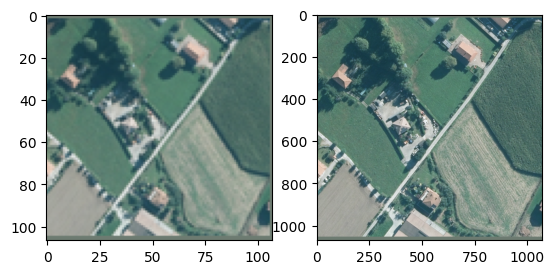

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image 1


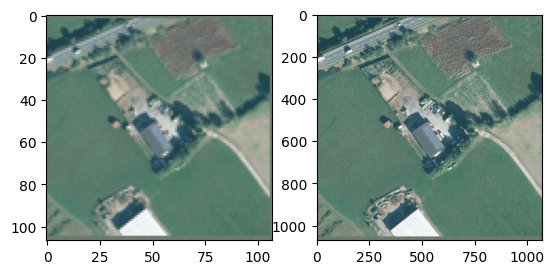

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image 2


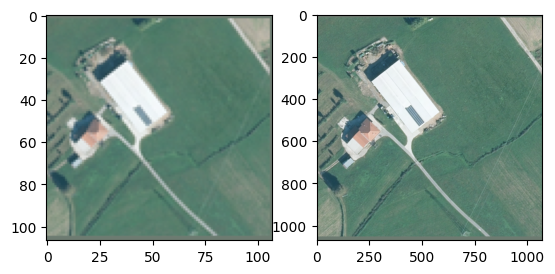

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image 3


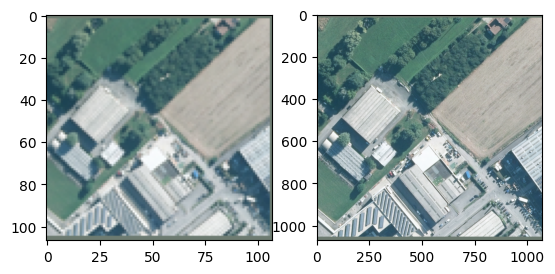

In [14]:
import matplotlib.pyplot as plt

print(img.size())
for i in range(len(img)):
    print(f'image {i}')
    pic = reverse_image_standardisation(img[i], rgb_means, rgb_stds)
    target_pic = reverse_image_standardisation(target[i], rgb_means, rgb_stds) 
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(torch.permute(pic, (2,1,0))) 
    ax[1].imshow(torch.permute(target_pic, (2,1,0)))
    plt.show()

In [106]:
print(img[0].size())

torch.Size([3, 110, 110])


In [71]:
print(img[0].max())

tensor(3.2141)


### Simple placeholder model class to run pipeline:

In [72]:
class SimpleModel(nn.Module):
    def __init__(self):       
        super(SimpleModel, self).__init__()
        self.up = nn.Upsample(scale_factor=10, mode='nearest')
        self.conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=1, stride=(1, 1))
        
    def forward(self, x):
        x = self.up(x)
        x = F.relu(self.conv(x))
        return x

In [73]:
model = SimpleModel()

# input data is assumed to be of the form Batch x C x H x W
# unsqueezing image to add batch dimension
test_img = torch.unsqueeze(img[0], dim=0)
test_out = model(test_img)
print(test_img.size(), test_out.size())

torch.Size([1, 3, 110, 110]) torch.Size([1, 3, 1100, 1100])
